# Create a Convolutional Neural Network using MNIST dataset
## Using PyTorch

In [2]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 2.3.0+cpu
NumPy version:  1.26.4


### Loading and preprocessing the data

In [12]:
import torchvision 
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

In [13]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

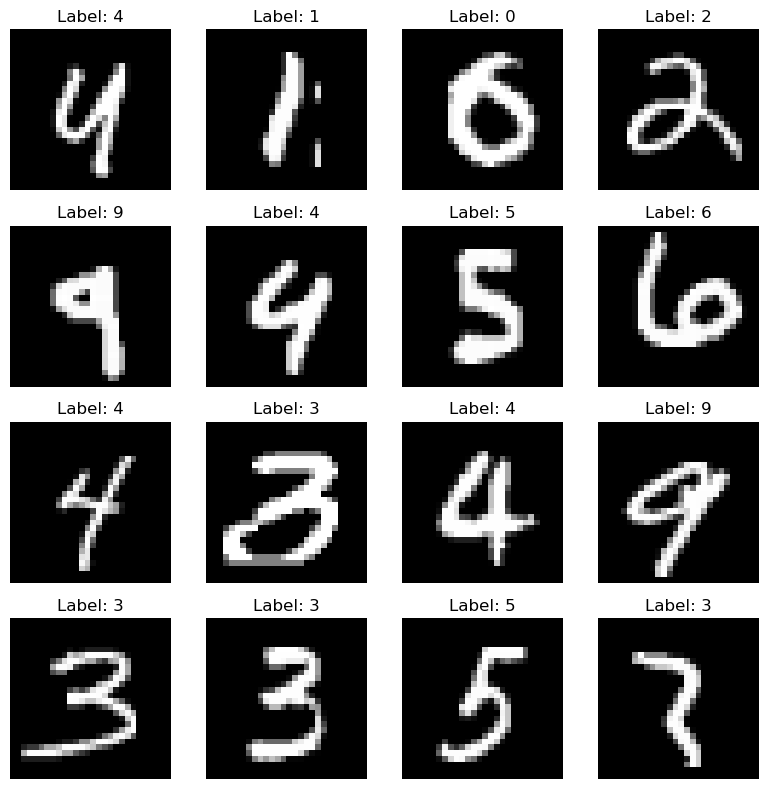

In [14]:
def plot_images(dataloader, num_images=16):
    fig, ax = plt.subplots(int(num_images**0.5), int(num_images**0.5), figsize=(8, 8))
    ax = ax.flatten()
    for i, (images, labels) in enumerate(dataloader):
        for j in range(num_images):
            ax[j].imshow(images[j][0], cmap='gray')  # Indexing [j][0] to get the first channel
            ax[j].set_title(f'Label: {labels[j]}')
            ax[j].axis('off')
        break  # Only get the first batch
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_images(train_dl)

### Constructing a CNN in PyTorch

In [15]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [16]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [17]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 

In [18]:
#device = torch.device("cuda:0") # To use the GPU for processing
device = torch.device("cpu")

model = model.to(device) 

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9502 val_accuracy: 0.9798
Epoch 2 accuracy: 0.9854 val_accuracy: 0.9845
Epoch 3 accuracy: 0.9894 val_accuracy: 0.9887
Epoch 4 accuracy: 0.9917 val_accuracy: 0.9885
Epoch 5 accuracy: 0.9928 val_accuracy: 0.9897
Epoch 6 accuracy: 0.9945 val_accuracy: 0.9914
Epoch 7 accuracy: 0.9949 val_accuracy: 0.9892
Epoch 8 accuracy: 0.9961 val_accuracy: 0.9905
Epoch 9 accuracy: 0.9968 val_accuracy: 0.9910
Epoch 10 accuracy: 0.9970 val_accuracy: 0.9902
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9909
Epoch 12 accuracy: 0.9972 val_accuracy: 0.9902
Epoch 13 accuracy: 0.9980 val_accuracy: 0.9903
Epoch 14 accuracy: 0.9979 val_accuracy: 0.9929
Epoch 15 accuracy: 0.9978 val_accuracy: 0.9915
Epoch 16 accuracy: 0.9983 val_accuracy: 0.9905
Epoch 17 accuracy: 0.9983 val_accuracy: 0.9901
Epoch 18 accuracy: 0.9976 val_accuracy: 0.9915
Epoch 19 accuracy: 0.9984 val_accuracy: 0.9905
Epoch 20 accuracy: 0.9989 val_accuracy: 0.9912


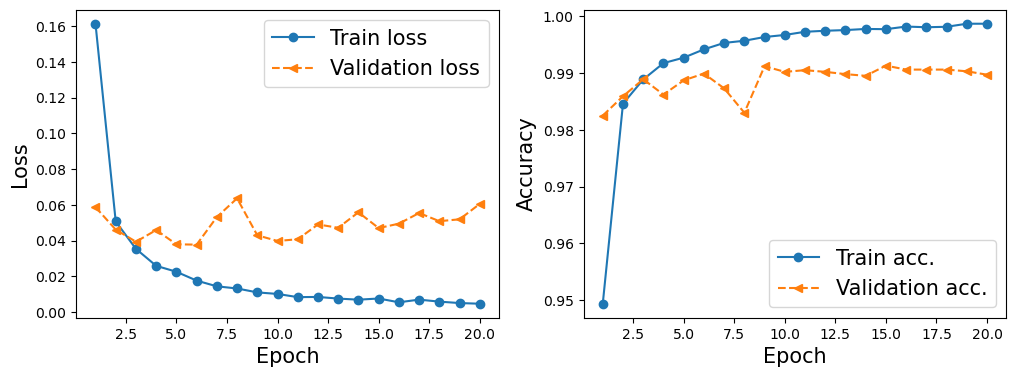

In [15]:
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [20]:
#torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9927


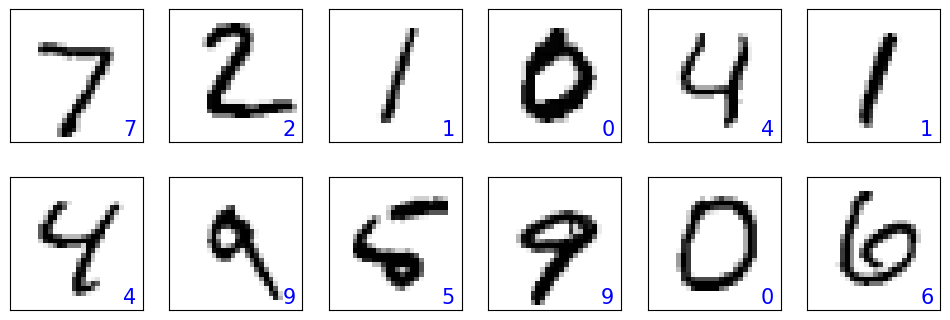

In [18]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/14_14.png')
plt.show()

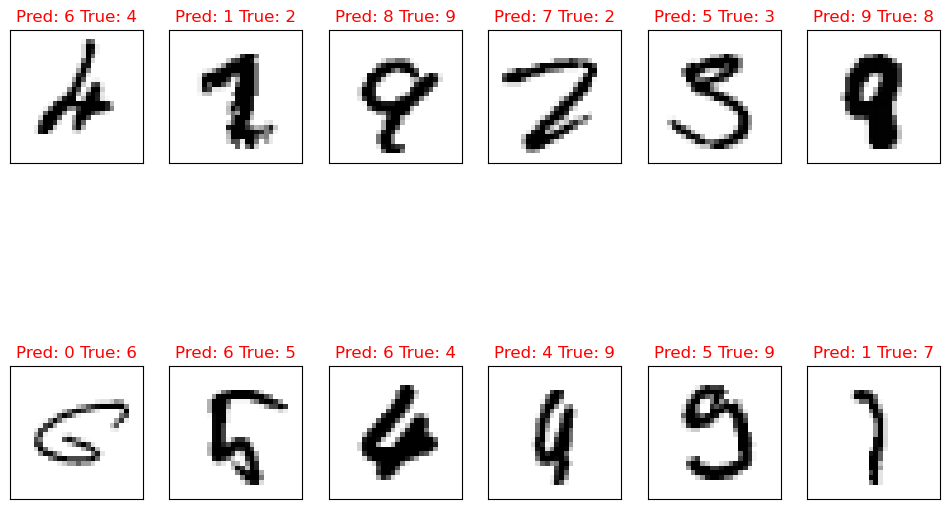

In [21]:
fig = plt.figure(figsize=(12, 8))
incorrect_count = 0

# Iterate over the test dataset
for i in range(len(mnist_test_dataset)):
    img, label = mnist_test_dataset[i][0], mnist_test_dataset[i][1]
    img = img.unsqueeze(0)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        pred = model(img)
    y_pred = torch.argmax(pred, dim=1).item()

    # Check if the prediction is incorrect
    if y_pred != label:
        incorrect_count += 1
        ax = fig.add_subplot(2, 6, incorrect_count)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img.squeeze(), cmap='gray_r')  # Squeeze to remove batch dimension for plotting
        ax.set_title(f"Pred: {y_pred} True: {label}", color='red')
        
        # Display only a certain number of incorrect samples
        if incorrect_count == 12:
            break

if incorrect_count == 0:
    plt.close(fig)  # Close the figure if no incorrect predictions were found
    print("No incorrect predictions found.")
else:
    plt.show()

In [20]:
# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')